In [ ]:
import numpy as np
import pandas as pd
import cvxopt
from cvxopt import matrix, solvers
import math
import matplotlib.pyplot as plt
from google.colab import output
solvers.options['show_progress'] = False

BASQP: Basic structure

In [ ]:
def mean_variance_model_cvxopt(ogarr, R, S):
  if (S==1):
    ww = np.zeros(len(ogarr[0]))
    ww[0] = 1
    return 1000000, ww
  temparr = ogarr[:,:S]
  return_rate = (temparr[:-1] - temparr[1:])/temparr[1:]
  exp_return = np.mean(return_rate,axis=0)
  temp_cov = np.cov(np.transpose(return_rate))
  num_companies = S

  temp_cov += np.eye(num_companies) * 1e-6
  e = np.ones(num_companies)

  P = matrix(2*temp_cov)
  q = matrix(np.zeros(num_companies))

  A = matrix(np.array([e, exp_return]))
  b = matrix(np.array([1,R]))

  G = matrix(-np.eye(num_companies))
  h = matrix(np.zeros(num_companies))
  sol = solvers.qp(P, q, G=G, h=h, A=A, b=b)

  wmw = np.array(sol['x'])
  wmw = wmw/sum(wmw)
  # print(wmw.shape)
  # print(temp_cov.shape)
  mkw_risk = math.sqrt(wmw.T@temp_cov@wmw)
  # print(mkw_risk,' : ',math.sqrt(sol['primal objective']))
  for _ in range(len(ogarr[0])-S):
    wmw = np.append(wmw,0)
  # mkw_risk = math.sqrt(sol['primal objective'])
  return mkw_risk, wmw

In [ ]:
def lowerLevelSolutionArray(ogarr, candidate_returns, candidate_number_of_assets):

  n = len(candidate_returns)
  minRisks = []

  for ind in range(n):
    solInd, ww = mean_variance_model_cvxopt(ogarr,candidate_returns[ind],candidate_number_of_assets[ind])
    minRisks.append(solInd)

  return np.array(minRisks)

In [ ]:
def crossover(candReturns, P, minRisks, candNumAssets, archiveS):
  n = len(candReturns)
  resultR = []
  resultS = []
  alpha = 0.01

  for _ in range(n):
    i = np.random.choice(np.arange(n), p=P)
    j = np.random.choice(np.arange(n), p=P)
    rand = np.random.uniform(0, 1)

    ansR = candReturns[i] + (alpha* rand)/minRisks[i] + (1 - rand) * (candReturns[j] - candReturns[i])
    ansS = round(candNumAssets[i] + rand*(archiveS - candNumAssets[i]) + (1 - rand)*(candNumAssets[j] - candNumAssets[i]))

    ansS = max(ansS,1)
    ansS = min(ansS,50)

    resultR.append(ansR)
    resultS.append(ansS)

  return resultR,resultS

def mutation(offReturns, candNumAssets, archiveR, archiveS, g):
  G = 10
  n = len(offReturns)
  F = 2**(1 - (g/G))

  resultR = []
  resultS = []

  for i in range(n):
    beta = np.random.normal()

    ansR = offReturns[i] + beta + F*(archiveR[0] - offReturns[i])
    ansS = candNumAssets[i] + round(F*(archiveS[0] - candNumAssets[i]) + beta)
    ansS = max(ansS,1)
    ansS = min(ansS,50)

    resultR.append(ansR)
    resultS.append(ansS)

  return resultR, resultS

In [ ]:
def next_candidate(mutR, mutS, candidate_returns, candidate_num_assets, ogarr, m=10):
  # Step 1: Get array of risks for the pairs (mutR[i], mutS[i])
  risks = lowerLevelSolutionArray(ogarr, mutR, mutS)
  cand_risks = lowerLevelSolutionArray(ogarr, candidate_returns, candidate_num_assets)

  # Step 2: Compute the primary function for mutR and risks (mutR[i] / Risk[i])
  mut_primary = [mutR[i] / risks[i] for i in range(len(mutR))]
  cand_primary = [candidate_returns[i] / cand_risks[i] for i in range(len(candidate_returns))]

  # Step 3: Combine both mut and archive lists
  combined_primary = cand_primary + mut_primary
  combined_returns = candidate_returns + mutR
  combined_assets = candidate_num_assets + mutS

  # Step 4: Sort combined lists based on primary function in descending order
  sorted_indices = np.argsort(combined_primary)[::-1]

  # Step 5: Keep only the top 'm' elements
  resultP = [combined_primary[i] for i in sorted_indices[:m]]
  resultR = [combined_returns[i] for i in sorted_indices[:m]]
  resultS = [combined_assets[i] for i in sorted_indices[:m]]

  return resultR, resultS, resultP


In [ ]:
# function defined assuming that the expected returns are in increasing order. Fulfill it before applying.
def BASQP(ogarr):
  n = len(ogarr[0]) # update with total number of assets
  incLimit = 0.01 # for termination condition
  improvement = 10
  allowedDiff = 0.001

  numValues = 40  # Number of random values
  candidate_returns = np.random.uniform(0, 1, numValues)
  # print(random_returns)

  d = int(0.3*n)
  candidate_num_assets = np.random.randint(1, d+1, numValues)
  # print(random_integers)

  ArchiveSetReturns = []
  ArchiveSetNumAssets = []
  ArchiveSetPrimary = []

  g = 0

  while (improvement > incLimit or g < 10):
    minRisks = lowerLevelSolutionArray(ogarr, candidate_returns, candidate_num_assets)

    ProbSelection = []
    bestInd = []
    bestVal = -1

    for ind in range(len(minRisks)):
      checkVal = max(1e-13,candidate_returns[ind]/minRisks[ind])
      ProbSelection.append(checkVal)
      if (checkVal > bestVal):
        bestVal = checkVal

    ProbSelection /= sum(ProbSelection)

    ArchiveCandidateReturns = []
    ArchiveCandidateNumAssets = []
    ArchiveCandidatePrimary = []

    for ind in range(len(minRisks)):
      checkVal = candidate_returns[ind]/minRisks[ind]
      if (abs(checkVal - bestVal) < allowedDiff):
        ArchiveCandidateReturns.append(candidate_returns[ind])
        ArchiveCandidateNumAssets.append(candidate_num_assets[ind])
        ArchiveCandidatePrimary.append(checkVal)

    # update archive set if new max found
    if (not ArchiveSetPrimary) or (ArchiveSetPrimary[0] < ArchiveCandidatePrimary[0]):
      ArchiveSetReturns = ArchiveCandidateReturns
      ArchiveSetNumAssets = ArchiveCandidateNumAssets
      ArchiveSetPrimary = ArchiveCandidatePrimary

    # Crossover
    offR, offS = crossover(candidate_returns, ProbSelection, minRisks, candidate_num_assets, ArchiveSetNumAssets[0])

    # Mutation
    mutR, mutS = mutation(offR, offS, ArchiveSetReturns, ArchiveSetNumAssets, g)

    # O = Oc U Om
    nextGenR = offR + mutR
    nextGenS = offS + mutS

    # Select top num_values
    candidate_returns, candidate_num_assets, candidate_primary = next_candidate(nextGenR, nextGenS, ArchiveCandidateReturns, ArchiveCandidateNumAssets, ogarr, numValues)
    improvement = candidate_primary[0] - ArchiveSetPrimary[0]
    # Break if number of iterations exceed limit : 1e4 (for safety) --> Print to check correctness
    g += 1
    if (g > 100):
      break

  # Return Archive Set
  return ArchiveSetReturns[0], ArchiveSetNumAssets[0], ArchiveSetPrimary[0]

Data Collection

In [ ]:
pricesDF = pd.read_csv('/content/drive/MyDrive/OMF_data_final/uploaded_data_2/Dataset_2_csv.csv')
pricesDF = pricesDF[pricesDF.columns[1:]]

pricesNP = pricesDF.to_numpy()
return_rate = (pricesNP[:-1] - pricesNP[1:])/pricesNP[1:]
exp_return = np.mean(return_rate,axis=0)

sorted_indices = np.argsort(exp_return)
sorted_pricesNP = pricesNP[:, sorted_indices]

In [ ]:
window = 30
num_days = len(pricesDF.index)
num_companies = pricesDF.columns.size
total_rows = num_days - window # Modified(decreased by 1) as we are checking with actual returns

In [ ]:
weights = []

Original algo: Based on return rate

In [ ]:
for i in range(total_rows):
  temp_price_df = pricesDF[i:i+window]
  temp_price_np = temp_price_df.to_numpy()

  temp_return_rate = (temp_price_np[:-1] - temp_price_np[1:])/temp_price_np[1:]
  temp_exp_return = np.mean(temp_return_rate,axis=0)

  temp_sorted_indices = np.argsort(temp_exp_return)
  temp_sorted_price_np = temp_price_np[:, temp_sorted_indices]

  temp_FinR, temp_FinS, temp_FinP = BASQP(temp_sorted_price_np)
  temp_riskInvolved, temp_reqWeights = mean_variance_model_cvxopt(temp_sorted_price_np, temp_FinR, temp_FinS)

  # Reorder `temp_reqWeights` to match the original order
  reordered_weights = np.zeros_like(temp_reqWeights)
  reordered_weights[temp_sorted_indices] = temp_reqWeights

  weights.append(reordered_weights)

In [ ]:
weights_df = pd.DataFrame(weights)
weights_df.to_csv("weights_og_bilevel.csv", index=False, header=False)

Modified : To be on the basis of variance

In [ ]:
weights1 = []

In [ ]:
for i in range(total_rows):
  temp_price_df = pricesDF[i:i+window]
  temp_price_np = temp_price_df.to_numpy()

  temp_return_rate = (temp_price_np[:-1] - temp_price_np[1:])/temp_price_np[1:]
  temp_exp_return = np.mean(temp_return_rate,axis=0)

  temp_variance = np.var(temp_return_rate, axis=0)

  # Sort indices by increasing order of variance
  temp_sorted_indices = np.argsort(temp_variance)

  # Reorder columns of prices array by sorted variance
  temp_sorted_price_np = temp_price_np[:, temp_sorted_indices]

  temp_FinR, temp_FinS, temp_FinP = BASQP(temp_sorted_price_np)
  temp_riskInvolved, temp_reqWeights = mean_variance_model_cvxopt(temp_sorted_price_np, temp_FinR, temp_FinS)

  # Reorder `temp_reqWeights` to match the original order
  reordered_weights = np.zeros_like(temp_reqWeights)
  reordered_weights[temp_sorted_indices] = temp_reqWeights

  weights1.append(reordered_weights)

<ipython-input-19-4a526ec5c979>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mkw_risk = math.sqrt(wmw.T@temp_cov@wmw)


In [ ]:
weights1_df = pd.DataFrame(weights1)
weights1_df.to_csv("weights_var_bilevel.csv", index=False, header=False)

Comparing Results

In [ ]:
weights_var_bilevel_df = pd.read_csv('/content/drive/MyDrive/Weights without transaction cost/BiLevel Solution Weights/weights_var_cvxopt.csv')
weights_var_bilevel = weights_var_bilevel_df.to_numpy()
weights_var_bilevel = weights_var_bilevel[1:]

weights_og_bilevel_df = pd.read_csv('/content/drive/MyDrive/Weights without transaction cost/BiLevel Solution Weights/weights_cvxopt.csv')
weights_og_bilevel = weights_og_bilevel_df.to_numpy()
weights_og_bilevel = weights_og_bilevel[1:]

In [ ]:
return_at_weights_variance_bilevel = []
return_at_weights_og_bilevel = []
day = []

In [ ]:
for i in range(num_days-window-2):
  rog = weights_og_bilevel[i]@return_rate[i] # Because the first row has been removed from weights
  return_at_weights_og_bilevel.append(rog)

  rvar = weights_var_bilevel[i]@return_rate[i]
  return_at_weights_variance_bilevel.append(rvar)

  day.append(i+1)

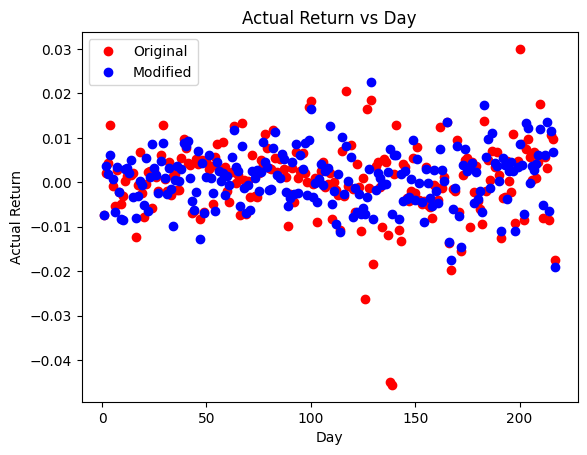

In [ ]:
plt.plot(day,return_at_weights_og_bilevel,'o',color='r',label='Original')
plt.plot(day,return_at_weights_variance_bilevel,'o',color='b',label='Modified')
plt.xlabel('Day')
plt.ylabel('Actual Return')
plt.title('Actual Return vs Day')
plt.legend()
plt.show()

In [ ]:
print(sum(return_at_weights_variance_bilevel))
print(sum(return_at_weights_og_bilevel))

0.1844175204409447
0.10564203300462627


In [ ]:
primary_objective_og = []
primary_objective_var = []
expected_return_og = []
expected_return_var = []
day_primary = []

In [ ]:
for i in range(1,total_rows-1):
  temp_price_df = pricesDF[i:i+window]
  temp_price_np = temp_price_df.to_numpy()

  temp_return_rate = (temp_price_np[:-1] - temp_price_np[1:])/temp_price_np[1:]
  temp_exp_return = np.mean(temp_return_rate,axis=0)

  temp_cov = np.cov(np.transpose(temp_return_rate))

  return_og = weights_og_bilevel[i-1]@temp_exp_return
  expected_return_og.append(return_og)
  return_var = weights_var_bilevel[i-1]@temp_exp_return
  expected_return_var.append(return_var)

  risk_og = math.sqrt(weights_og_bilevel[i-1].T@temp_cov@weights_og_bilevel[i-1])
  risk_var = math.sqrt(weights_var_bilevel[i-1].T@temp_cov@weights_var_bilevel[i-1])

  primary_objective_og.append(return_og/risk_og)
  primary_objective_var.append(return_var/risk_var)
  day_primary.append(i-1)

In [ ]:
print(sum(primary_objective_og))
print(sum(primary_objective_var))

-31.66626521780386
7.306817369597291


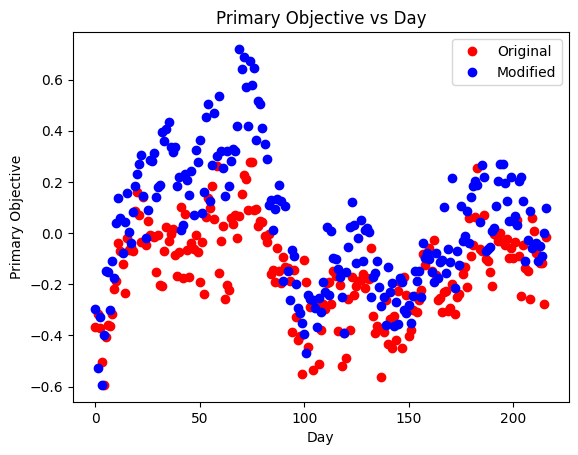

In [ ]:
plt.plot(day_primary,primary_objective_og,'o',color='r',label='Original')
plt.plot(day_primary,primary_objective_var,'o',color='b',label='Modified')
plt.xlabel('Day')
plt.ylabel('Primary Objective')
plt.title('Primary Objective vs Day')
plt.legend()
plt.show()

In [ ]:
diff_og = []
diff_var = []

for i in range(len(primary_objective_og)):
  diff_og.append(abs(expected_return_og[i]-return_at_weights_og_bilevel[i]))
  diff_var.append(abs(expected_return_var[i]-return_at_weights_variance_bilevel[i]))

In [ ]:
print(sum(diff_og))
print(sum(diff_var))

1.3572340879086147
1.113379296696308


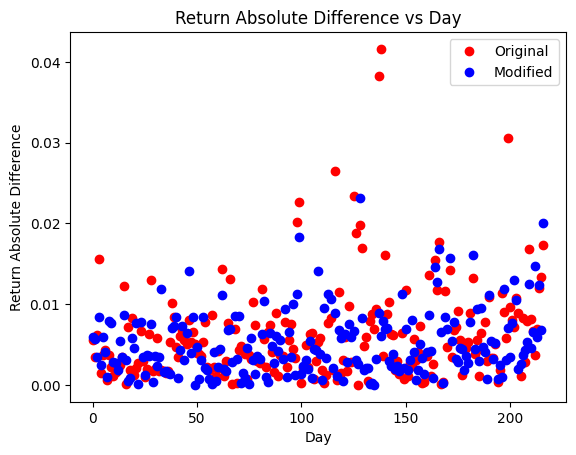

In [ ]:
plt.plot(day_primary,diff_og,'o',color='r',label='Original')
plt.plot(day_primary,diff_var,'o',color='b',label='Modified')
plt.xlabel('Day')
plt.ylabel('Return Absolute Difference')
plt.title('Return Absolute Difference vs Day')
plt.legend()
plt.show()